# Convolutional Neural Network

In [122]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import mnist
%matplotlib inline

### Load Images and create kernels

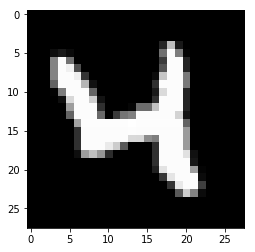

In [123]:
image = mnist.train_images()[20]
plt.imshow(image, cmap='gray')

### Convolution
Funtion to perform a convolution for each kernel in kernelArray

In [124]:
def singleConvolution(image, kernel):
    imageW, imageH = image.shape
    kernelW, kernelH = kernel.shape
    
    convolvedImage = np.zeros((imageW-kernelW, imageH-kernelH))
    
    for i in range(imageW-kernelW):
        for j in range(imageH-kernelH):
            auxMatrix = image[i:i+kernelW,j:j+kernelH] * kernel
            convolvedImage[i, j] = auxMatrix.sum()
    return convolvedImage
            

def convolveImage(image, kernelArray):
    return np.array([ singleConvolution(image, kernel) for kernel in kernelArray ])
    

### Random Kernels

In [125]:
NUMBER_KERNELS = 10
kernels = np.random.randn(NUMBER_KERNELS,5,5) / 9

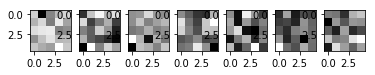

In [126]:
fig, axs = plt.subplots(1, min(NUMBER_KERNELS, 7))
for i in range(min(NUMBER_KERNELS, 7)):
    axs[i].imshow(kernels[i], cmap='gray')

### Apply kernels into the image

In [127]:
imagesConvolved = convolveImage(image, kernels)

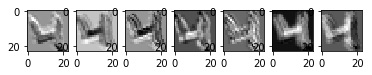

In [128]:
fig, axs = plt.subplots(1, min(NUMBER_KERNELS, 7))
for i in range(min(NUMBER_KERNELS, 7)):
    axs[i].imshow(imagesConvolved[i], cmap='gray')

### Pooling 
Apply an algorithm to group or reduce similar values to a simpler image

In [129]:
def pool(image, size = 2, function = np.max):
    w, h = image.shape
    sizeHorizontal = w // size
    sizeVertical = h // size

    ansImage = np.zeros([sizeVertical, sizeHorizontal])

    for i in range(sizeHorizontal):
        for j in range(sizeVertical):
            ansImage[i,j] = function(image[i*size:(i+1)*size, j*size:(j+1)*size])
    return ansImage

def poolImages(images, function=np.max):
    return np.array([pool(image, function=function, size = 2) for image in images])

### Apply pooling to the convolved images

In [130]:
imagesPooled = poolImages(imagesConvolved, function=np.median)

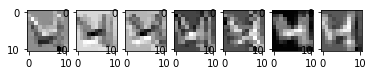

In [131]:
fig, axs = plt.subplots(1, min(NUMBER_KERNELS, 7))
for i in range(min(NUMBER_KERNELS, 7)):
    axs[i].imshow(imagesPooled[i], cmap='gray')

### Neural Layer
Now each processed image is flatted into a single array, and all pixel is treated as an input in our neural network

![Image of Yaktocat](images/CNN.svg)

In [132]:
def generateWeights(images, output):
    inputlayer = np.prod(images.shape)
    weights = np.random.randn(inputlayer, output)
    return weights

### Generate weights for conections

In [133]:
weights = pd.DataFrame(generateWeights(imagesPooled, 10))
weights.tail()

,0,1,2,3,4,5,6,7,8,9
1205,0.776549,-0.333465,0.251201,0.004017,1.831800,1.706992,-1.064312,1.374072,-0.267336,-1.131541
1206,0.916544,0.512598,-0.368010,-0.201294,-0.921517,0.863633,0.977699,0.291661,0.193330,0.254531
1207,0.444147,2.428543,0.827577,-0.109376,-0.301847,-1.848073,0.712963,-1.141987,1.239912,-1.279018
1208,-0.251856,0.217106,-0.740055,0.200133,-0.802422,-0.732253,1.464589,-1.111082,-1.404028,-0.920187
1209,0.449845,-1.872413,0.942781,0.301312,-1.242412,-0.356027,-0.507029,-0.403227,0.791349,-0.126301


In [259]:
def forwardSoftmax(imageDf, weightsDf):
    totals = ( 
        imageDf
        .transpose()
        .dot(weightsDf)
        .apply(np.exp)
    )
    return totals

In [278]:
imageDf = pd.DataFrame(imagesPooled.flatten())
a = forwardSoftmax(imageDf, weights)
(a / a.sum(axis=1))

,0,1,2,3,4,5,6,7,8,9
0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [274]:
np.exp(a[1]) / 11773.379832

0    0.000085
Name: 1, dtype: float64

# Test CNN 

In [136]:
test_images = mnist.test_images()[:1000]
test_labels = mnist.test_labels()[:1000]